In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [3]:
data = np.array(data)#, dtype="float") / 255.0
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 3))
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 2)

In [4]:
print(data.shape, labels.shape)

(726, 224, 224, 3) (726, 2)


In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.40, stratify=labels, random_state=42)

In [6]:
opt = Adam(lr=1e-4, decay=1e-4 / 5)

C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [9]:
from tensorflow.keras.applications import ResNet101

model = ResNet101(weights = 'imagenet', include_top=True, input_shape=(224, 224, 3))
output = Dense(2, activation='softmax')(model.layers[-2].output)
model = Model(model.input, output)
model.summary()

179650560/179648224 [==============================] - 35s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [10]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [11]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs',write_graph=True, write_images=False)

In [12]:
H = model.fit(x=trainX, y=trainY, validation_data=(testX, testY),batch_size=16, callbacks=[tensorboard], epochs=5, verbose=1)

C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
28/28 [==============================] - 23s 411ms/step - loss: 0.0702 - accuracy: 0.9701 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/5
28/28 [==============================] - 7s 252ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9966
Epoch 3/5
28/28 [==============================] - 7s 253ms/step - loss: 6.4834e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9966
Epoch 4/5
28/28 [==============================] - 7s 254ms/step - loss: 4.6646e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9966
Epoch 5/5
28/28 [==============================] - 7s 254ms/step - loss: 0.0125 - accuracy: 0.9977 - val_loss: 7.9710e-04 - val_accuracy: 1.0000


In [13]:
model.save("weatherRes100.h5")

In [14]:
y_pred = model.predict(testX)

In [15]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))    
    labels = [0,1]
    cmap=sns.light_palette("blue")    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")    
    plt.show()

In [16]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(testY, axis=1)

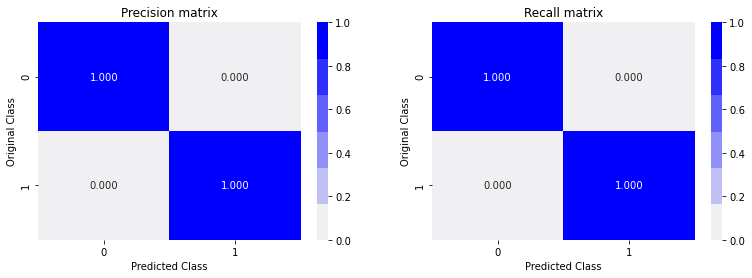

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plot_confusion_matrix(y_test, y_pred)

In [19]:
path = 'dataset/cyclone/'
classes = ['cyclone', 'non-cyclone']
for j, images in enumerate(os.listdir(path)):
    image = path + images
    img =cv2.imread(image)
    img1 = cv2.resize(img, (224,224))
    img2 = np.expand_dims(img1,axis=0)
    i = model.predict(img2)[0]
    label = classes[np.argmax(i)]
    print(label)
    cv2.putText(img,label,(10,40),cv2.FONT_HERSHEY_COMPLEX,2,(255,255,255),2)
    name = image.split('/')[2]
    cv2.imwrite('graphs/output/classify/' + name+ '.jpg', img)
    if j > 1:
        break

cyclone
cyclone
cyclone


In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

model = load_model("weatherRes100.h5")
#model.summary()
IMAGE_PATH = 'dataset/cyclone/2.jpg'
LAYER_NAME = 'conv5_block3_out'

img =cv2.imread(IMAGE_PATH)
img1 = cv2.resize(img, (224,224))
img2 = np.expand_dims(img1,axis=0)

i = model.predict(img2)[0]
print(i)
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img1]))
    loss = predictions[:,0]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]  * 1e+08
gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
denom = (cam.max() - cam.min()) + 1e-16
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / denom
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
print(img.shape, cam.shape)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('graphs/output/2.png', output_image)

[9.9999881e-01 1.2179509e-06]
(1234, 1350, 3) (1234, 1350, 3)


True